# Opensky with GraphX Project

Use case : Flight tracking with OpenSky

## Imports

In [1]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, IntegerType, TimestampType, FloatType, BooleanType
from prometheus_client import CollectorRegistry, Gauge, push_to_gateway

from pyspark.sql.functions import col, desc, sum, mean, min, max, lit, coalesce, bucket, col, window, avg ,count,from_json, when, current_timestamp, countDistinct
from matplotlib.pylab import mean

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md

import networkx as nx

from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure, from_networkx
from bokeh.models import HoverTool, ColumnDataSource
from bokeh.transform import linear_cmap
from bokeh.palettes import Viridis256

## Conf spark

In [2]:
conf = SparkConf() \
    .setAppName('SparkApp') \
    .setMaster('spark://spark:7077') \
    .set("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.3.4,org.apache.spark:spark-sql-kafka-0-10_2.12:3.5.3,graphframes:graphframes:0.8.4-spark3.5-s_2.12") \
    .set("spark.sql.shuffle.partitions", "10")

# Build the SparkSession using the unified configuration
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Get the SparkContext from the SparkSession (if needed)
sc = spark.sparkContext
sc.setCheckpointDir("/tmp/graphframes-checkpoint")
# Create a SQLContext (if needed for legacy operations)
sql_context = SQLContext(sc)

print("SparkSession and SparkContext successfully created.")

:: loading settings :: url = jar:file:/opt/conda/lib/python3.12/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7e783a0c-7538-404b-a7ec-f4d3b4274cd3;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.3.4 in central
	found com.amazonaws#aws-java-sdk-bundle;1.12.262 in central
	found org.wildfly.openssl#wildfly-openssl;1.0.7.Final in central
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.5.3 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.5.3 in central
	found org.apache.kafka#kafka-clients;3.4.1 in central
	found org.lz4#lz4-java;1.8.0 in central
	found org.xerial.snappy#snappy-java;1.1.10.5 in central
	found org.slf4j#slf4j-api;2.0.7 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.4 in central
	found org.apac

SparkSession and SparkContext successfully created.


25/02/21 19:46:43 WARN SparkContext: Spark is not running in local mode, therefore the checkpoint directory must not be on the local filesystem. Directory '/tmp/graphframes-checkpoint' appears to be on the local filesystem.
/opt/conda/lib/python3.12/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:

from graphframes import GraphFrame

## Configuration kafka et spark (non obligatoire si défini ailleurs)

In [4]:
flights_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-flights") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

In [5]:
schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("firstSeen", LongType(), True),
    StructField("estDepartureAirport", StringType(), True),
    StructField("lastSeen", LongType(), True),
    StructField("estArrivalAirport", StringType(), True),
    StructField("estDepartureAirportHorizDistance", LongType(), True),
    StructField("estDepartureAirportVertDistance", LongType(), True),
    StructField("estArrivalAirportHorizDistance", LongType(), True),
    StructField("estArrivalAirportVertDistance", LongType(), True),
    StructField("departureAirportCandidatesCount", LongType(), True),
    StructField("arrivalAirportCandidatesCount", LongType(), True)
])

flights_json = flights_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")


## Requêtes en mode batch, avec état.
### Mode batch avec fenêtre

In [6]:
arrival_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-arrivals") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

arrival_json = arrival_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")

25/02/21 19:47:02 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Text(0.5, 1.0, "Nombre d'arrivés par heures")

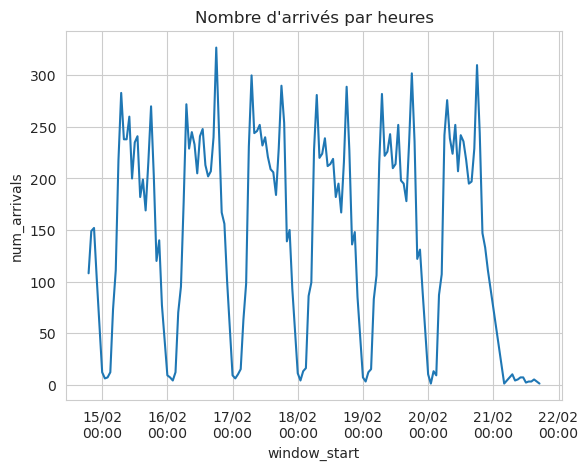

In [7]:
# Parse Kafka messages
parsed_stream = arrival_df.selectExpr("CAST(value AS STRING) AS message") \
    .select(from_json(col("message"), schema).alias("data")) \
    .select(
        col("data.lastSeen").cast(TimestampType()).alias("ArrivalTime"),
        col("data.estArrivalAirport").alias("Airport")
    )

# Compute number of arrivals over a 60-minute window
rolling_numbers = parsed_stream \
    .groupBy(window(col("ArrivalTime"), "60 minutes")) \
    .count() \
    .select(
        col("window.start").alias("window_start"),
        col("window.end").alias("window_end"),
        col("count").alias("num_arrivals")
    ).orderBy("window_start")

# Collect the result as a Pandas DataFrame
pandas_df = rolling_numbers.toPandas()
pandas_df

g = sns.lineplot(data=pandas_df, x="window_start", y="num_arrivals")
g.xaxis.set_major_formatter(md.DateFormatter('%d/%m\n%H:%M'))
g.set_title("Nombre d'arrivés par heures")

### Mode batch sans fenêtre

In [8]:
flight_counts = arrival_json \
    .groupBy("estDepartureAirport", "estArrivalAirport") \
    .count() \
    .withColumnRenamed("count", "flight_count")

# Créer un DataFrame pour les arêtes (vols)
nbVols = flight_counts.select(
    col("estDepartureAirport").alias("src"),
    col("estArrivalAirport").alias("dst"),
    col("flight_count")
)
# on se limite au 15 aéroports les plus fréquentés
top_n = 15

# Identifier les aéroports les plus fréquentés (combinaison de départs et arrivées)
top_airports = (
    flight_counts.select("estDepartureAirport").union(flight_counts.select("estArrivalAirport"))
    .groupBy("estDepartureAirport").count()
    .orderBy(desc("count"))
    .limit(top_n)
    .select("estDepartureAirport").collect()
)
top_airport_codes = [row['estDepartureAirport'] for row in top_airports]

# Filtrer le dataframe pour n'inclure que les vols entre ces aéroports principaux
filtered_counts = flight_counts.filter(
    (col("estDepartureAirport").isin(top_airport_codes)) & 
    (col("estArrivalAirport").isin(top_airport_codes))
)

filtered_counts

25/02/21 19:47:25 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 19:47:25 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


DataFrame[estDepartureAirport: string, estArrivalAirport: string, flight_count: bigint]

25/02/21 19:47:28 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+----+------------+
| src| dst|flight_count|
+----+----+------------+
|LEBL|LEMD|         117|
|LPPT|LEMD|         114|
|LEMD|LEBL|         113|
|EGLL|EHAM|         100|
|EGLL|EDDF|          99|
|LEPA|LEBL|          95|
|LIRF|LEMD|          94|
|EGLL|LFPG|          90|
|EGLL|EDDM|          87|
|LEMD|LIRF|          86|
|EDDF|EDDB|          85|
|EGLL|LEMD|          84|
|LFPG|EHAM|          82|
|EDDM|EDDF|          82|
|EDDF|EDDM|          82|
+----+----+------------+



25/02/21 19:47:31 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


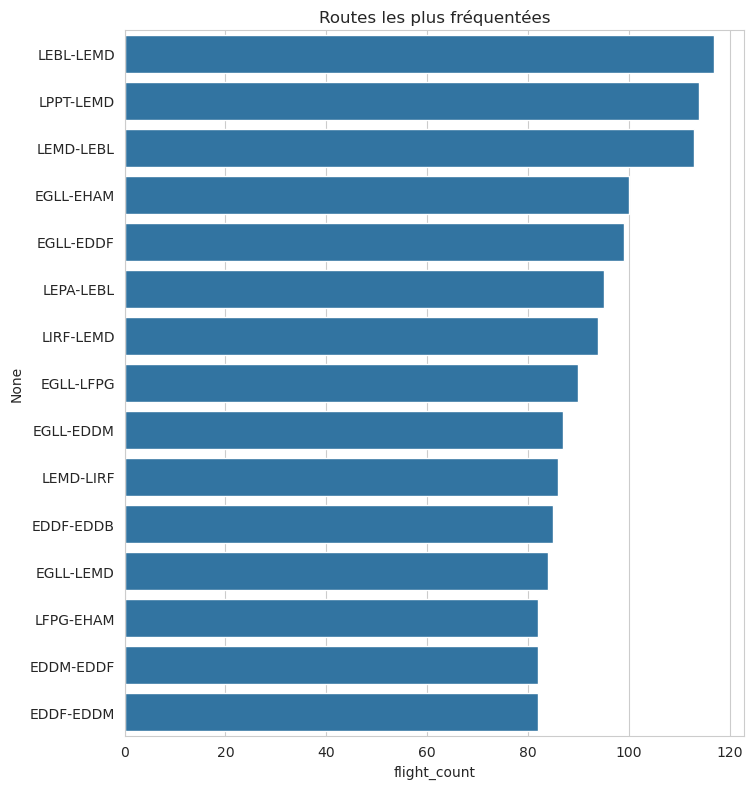

In [9]:
# Filtrer les données qui valent NULL
filtered_nbVols = nbVols.filter(
    (col("src").isNotNull()) & 
    (col("dst").isNotNull())
)

# Trouver les routes les plus empruntées
top_routes = filtered_nbVols.orderBy(desc("flight_count")).limit(top_n)
top_routes.show()

# Convertir en pandas pour visualisation avec Seaborn
top_routes_pd = top_routes.toPandas()

# Créer des visualisations
plt.figure(figsize=(14, 8))

# Graphique des routes les plus fréquentées
plt.subplot(1, 2, 2)
sns.barplot(x="flight_count", y=top_routes_pd.apply(lambda x: f"{x['src']}-{x['dst']}", axis=1), 
            data=top_routes_pd, orient="h")
plt.title("Routes les plus fréquentées")
plt.tight_layout()

plt.savefig("aviation_network_analysis.png")
plt.show()
plt.close()

In [10]:
# Convertir en pandas pour le pivot
matrix_data = filtered_counts.toPandas()

# Créer la matrice pivot
flight_matrix = matrix_data.pivot(index='estDepartureAirport', columns='estArrivalAirport', values='flight_count')
flight_matrix = flight_matrix.fillna(0)  # Remplacer les NaN par 0

# Créer le heatmap
plt.figure(figsize=(16, 12))
ax = sns.heatmap(
    flight_matrix,
    annot=True,           # Afficher les valeurs
    fmt='g',              # Format des nombres (entiers)
    cmap='YlGnBu',        # Palette de couleurs (jaune-vert-bleu)
    linewidths=0.5,       # Lignes entre les cellules
    cbar_kws={'label': 'Nombre de vols'}
)

# Ajuster les étiquettes et le titre
plt.title('Nombre de vols entre les principaux aéroports', fontsize=16)
plt.xlabel('Destinations', fontsize=12)
plt.ylabel('Origines', fontsize=12)

# Rotation des étiquettes pour la lisibilité
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Ajuster la mise en page
plt.tight_layout()

# Sauvegarder et afficher
plt.savefig("/tmp/flight_heatmap_origin_destination.png", dpi=300)
# plt.show()
plt.close()

# Obtenir quelques statistiques sur cette matrice
nonzero_routes = (flight_matrix > 0).sum().sum()
total_possible_routes = len(top_airport_codes) * len(top_airport_codes)
connectivity_ratio = nonzero_routes / total_possible_routes

print(f"Parmi les {top_n} principaux aéroports:")
print(f"Nombre total de routes possibles: {total_possible_routes}")
print(f"Nombre de routes effectivement desservies: {nonzero_routes}")
print(f"Ratio de connectivité: {connectivity_ratio:.2%}")
print(f"Nombre moyen de vols par route active: {flight_matrix.sum().sum() / nonzero_routes:.1f}")

25/02/21 19:47:33 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Parmi les 15 principaux aéroports:
Nombre total de routes possibles: 225
Nombre de routes effectivement desservies: 122
Ratio de connectivité: 54.22%
Nombre moyen de vols par route active: 36.2


## Requête avec SparkSQL

In [11]:
# Enregistrer le DataFrame en tant que table temporaire
flights_json.createOrReplaceTempView("flights")

# Top 5 de la correspondance la plus fréquente
query = """
SELECT estDepartureAirport, estArrivalAirport, COUNT(*) as count
FROM flights
WHERE estDepartureAirport IS NOT NULL AND estArrivalAirport IS NOT NULL AND estDepartureAirport != estArrivalAirport
GROUP BY estDepartureAirport, estArrivalAirport
ORDER BY count DESC
LIMIT 5
"""

top_5_couples = sql_context.sql(query)

# Afficher les résultats
top_5_couples.show()

25/02/21 19:47:38 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+-------------------+-----------------+-----+
|estDepartureAirport|estArrivalAirport|count|
+-------------------+-----------------+-----+
|               KE25|             KDVT|   16|
|               CYVR|             CYYJ|   14|
|               PAEN|             PANC|   10|
|               KOPF|             KFLL|   10|
|               PANC|             PAEN|   10|
+-------------------+-----------------+-----+



## Requête en mode batch et résultats sous forme de graphiques

In [12]:
# Afficher un exemple brut
flights_df.selectExpr("CAST(value AS STRING)").show(5, False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|value                                                                                                                                                                                                                                                                                                                                                                                                |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

25/02/21 19:47:41 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


In [13]:
filtered_flights = flights_json.filter(
    (col("estDepartureAirport").isNotNull()) &
    (col("estArrivalAirport").isNotNull())
)

outbound = filtered_flights.groupBy("estDepartureAirport") \
    .agg(count("*").alias("vols_sortants")) \
    .orderBy(desc("vols_sortants"))

inbound = filtered_flights.groupBy("estArrivalAirport") \
    .agg(count("*").alias("vols_entrants")) \
    .orderBy(desc("vols_entrants"))


25/02/21 19:47:43 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 19:47:44 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
/tmp/ipykernel_2800/1064879125.py:9: FutureWarning:                             

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


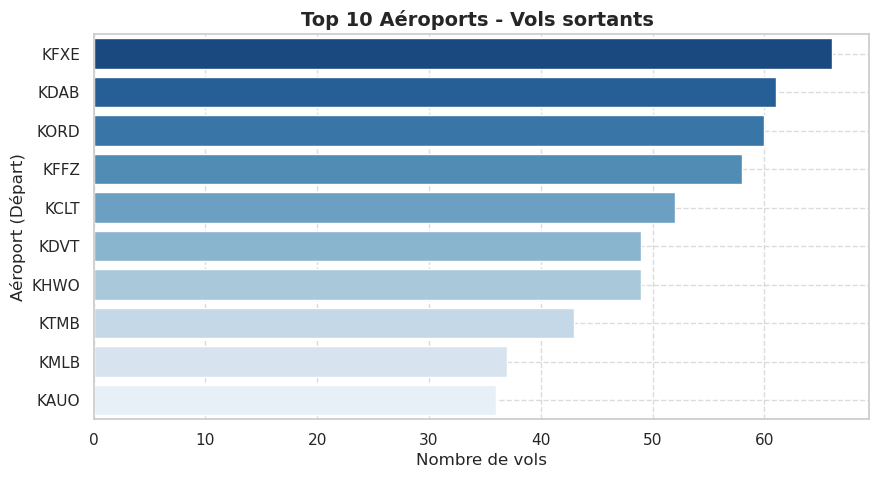

/tmp/ipykernel_2800/1064879125.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


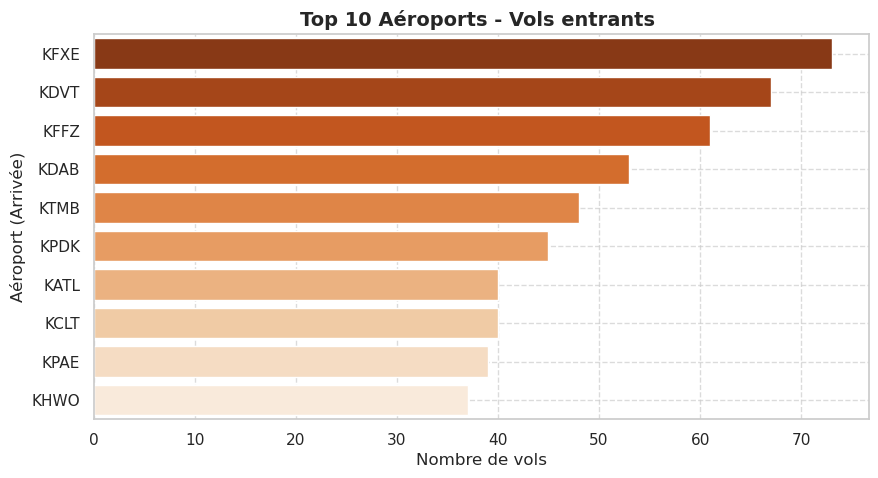

In [14]:
outbound_pd = outbound.limit(10).toPandas()
inbound_pd = inbound.limit(10).toPandas()

# 🎨 Configurer le style Seaborn
sns.set_theme(style="whitegrid", palette="muted")

# 📈 Vols sortants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_sortants",
    y="estDepartureAirport",
    data=outbound_pd,
    palette="Blues_r"
)
plt.title("Top 10 Aéroports - Vols sortants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Départ)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# 📊 Vols entrants
plt.figure(figsize=(10, 5))
sns.barplot(
    x="vols_entrants",
    y="estArrivalAirport",
    data=inbound_pd,
    palette="Oranges_r"
)
plt.title("Top 10 Aéroports - Vols entrants ", fontsize=14, fontweight='bold')
plt.xlabel("Nombre de vols")
plt.ylabel("Aéroport (Arrivée)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Spark streaming

### Definir the shema de données states

In [39]:
schema = StructType() \
    .add("icao24", StringType()) \
    .add("callsign", StringType()) \
    .add("origin_country", StringType()) \
    .add("time_position", DoubleType()) \
    .add("last_contact", DoubleType()) \
    .add("longitude", DoubleType()) \
    .add("latitude", DoubleType()) \
    .add("altitude", DoubleType()) \
    .add("on_ground", BooleanType()) \
    .add("velocity", DoubleType()) \
    .add("heading", DoubleType()) \
    .add("vertical_rate", DoubleType()) \
    .add("sensors", StringType()) \
    .add("geo_altitude", DoubleType()) \
    .add("squawk", StringType()) \
    .add("spi", BooleanType()) \
    .add("position_source", StringType())

### Création des Streaming Queries

In [40]:
df_filtered_flights = spark.readStream \
    .format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky_filtered_flights") \
    .option("startingOffsets", "earliest") \
    .load()

df_filtered_flights = df_filtered_flights.selectExpr("CAST(value AS STRING) as json_value") \
    .select(from_json(col("json_value"), schema).alias("data")) \
    .select("data.*") \
    .withColumn("event_time", current_timestamp())

df_filtered_windowed = df_filtered_flights.groupBy(
    window(col("event_time"), "1 minute"),
    col("origin_country")
).count()

df_bucketed = df_filtered_flights.withColumn(
    "altitude_range",
    when(col("altitude") < 5000, "Low")
    .when((col("altitude") >= 5000) & (col("altitude") < 15000), "Medium")
    .otherwise("High")
)

df_bucket_count = df_bucketed.groupBy(
    window(col("event_time"), "1 minute"),
    col("altitude_range")
).count()

In [41]:
from prometheus_client import CollectorRegistry, Gauge, push_to_gateway

def push_metrics_to_prometheus(df, epoch_id):
    registry = CollectorRegistry()
    
    gauge = Gauge(
        'filtered_flights_count', 
        'Count of filtered flights per country (per 1-minute window)', 
        ['origin_country'], 
        registry=registry
    )
    
    for row in df.collect():
        country = row['origin_country']
        count_val = row['count']
        gauge.labels(origin_country=country).set(count_val)
    
    push_to_gateway('pushgateway:9091', job='spark_filtered_flights', registry=registry)
    print(f"Epoch {epoch_id}: Metrics pushed to Prometheus Pushgateway.")

query_prometheus = df_filtered_windowed.writeStream \
    .outputMode("update") \
    .foreachBatch(push_metrics_to_prometheus) \
    .start()

query_prometheus.awaitTermination()


25/02/21 20:37:26 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-cce73991-299b-433b-bcd4-e187e126b8cb. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/21 20:37:26 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/02/21 20:37:26 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
            

KeyboardInterrupt: 

In [42]:
def push_bucket_metrics(df, epoch_id):
    registry = CollectorRegistry()
    
    gauge = Gauge(
        'bucketed_flights_count', 
        'Count of flights by altitude range per 1-minute window', 
        ['altitude_range'], 
        registry=registry
    )
    
    # Iterate over each row in the micro-batch DataFrame.
    # Each row should contain the altitude_range and its corresponding count.
    for row in df.collect():
        bucket = row['altitude_range']
        count_val = row['count']
        gauge.labels(altitude_range=bucket).set(count_val)
    
    # Push the metrics to the Pushgateway (ensure the host/port match your configuration)
    push_to_gateway('pushgateway:9091', job='spark_bucketed_flights', registry=registry)
    print(f"Epoch {epoch_id}: Bucket metrics pushed to Prometheus Pushgateway.")

# Attach the foreachBatch function to your bucketed query output
query_bucket_prom = df_bucket_count.writeStream \
    .outputMode("update") \
    .foreachBatch(push_bucket_metrics) \
    .start()

query_bucket_prom.awaitTermination()


25/02/21 20:40:02 WARN ResolveWriteToStream: Temporary checkpoint location created which is deleted normally when the query didn't fail: /tmp/temporary-38cac8be-dbcc-4e24-8297-0a0f71606993. If it's required to delete it under any circumstances, please set spark.sql.streaming.forceDeleteTempCheckpointLocation to true. Important to know deleting temp checkpoint folder is best effort.
25/02/21 20:40:02 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
25/02/21 20:40:02 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/opt/conda/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
            

KeyboardInterrupt: 

### Affichage des Streaming Queries

In [ ]:
query_bucket = df_bucket_count.writeStream \
    .outputMode("complete") \
    .format("console") \
    .queryName("bucket_console_query") \
    .start()

query_filtered = df_filtered_windowed.writeStream \
    .outputMode("update") \
    .format("console") \
    .queryName("filtered_console_query") \
    .start()

# Uncomment the following lines if you wish to block execution:
query_bucket.awaitTermination()
query_filtered.awaitTermination()

## GraphX with GraphFrames

> Installation de bokeh si déjà installée via requirements alors ce n'est pas nécessaire.

In [ ]:
!pip install bokeh


### Définition du schéma de données Kafka, lecture du feed et parsing

In [18]:
# Définition du schéma des données Kafka

schema = StructType([
    StructField("icao24", StringType(), True),
    StructField("firstSeen", LongType(), True),
    StructField("estDepartureAirport", StringType(), True),
    StructField("lastSeen", LongType(), True),
    StructField("estArrivalAirport", StringType(), True),
])

# Lecture du flux Kafka
flights_df = sql_context.read.format("kafka") \
    .option("kafka.bootstrap.servers", "kafka1:9092") \
    .option("subscribe", "opensky-flights") \
    .option("startingOffsets", "earliest") \
    .option("endingOffsets", "latest") \
    .load()

# Parsing du JSON contenu dans Kafka
flights_json = flights_df.select(from_json(col("value").cast("string"), schema).alias("data")).select("data.*")

### Définition des sommets arrêtes et graphe

In [19]:
# Création du DataFrame des sommets (aéroports)
# Suppression des doublons dans les sommets (aéroports)
vertices = flights_json.select(col("estDepartureAirport").alias("id")).distinct() \
    .union(flights_json.select(col("estArrivalAirport").alias("id")).distinct()) \
    .filter(col("id").isNotNull()) \
    .distinct()  # Suppression finale des doublons

In [20]:
# Création du DataFrame des arêtes (vols entre aéroports)
edges = flights_json.select(
    col("estDepartureAirport").alias("src"),
    col("estArrivalAirport").alias("dst")
).filter(col("src").isNotNull() & col("dst").isNotNull()) \
    .groupBy("src", "dst").agg(count("*").alias("weight"))

In [21]:
graph = GraphFrame(vertices, edges)

### Actions sur Graphe

#### Page Rank

In [22]:
pagerank_results = graph.pageRank(resetProbability=0.15, maxIter=10)
pagerank_results.vertices.select("id", "pagerank").show(100)

25/02/21 20:09:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:09:54 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:09:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:09:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:10:01 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:10:

+----+-------------------+
|  id|           pagerank|
+----+-------------------+
|K2W6| 1.4109435125570877|
|KLNS| 2.7433399166977113|
|VG01| 0.3372358795664847|
|KTTN| 5.4237697809081595|
|MI77| 0.3372358795664847|
|KCOI|  1.695512263042518|
|FL31|  0.733137581090833|
|KCHD| 3.9687145934141452|
|KGEU|   4.19355681081376|
|KOFP| 2.3083412517777404|
|KPDK|  5.725479565703667|
|KORF|  4.483594272797089|
|22FA| 1.9199124340085585|
|KVRB|  0.580677904260196|
|LSZH| 2.9919221025773677|
|KSOP| 1.6747755190646214|
|KADS|  8.419903780092255|
|KCLT|  5.719406934984599|
|KGVL| 1.8021867328065642|
|KMKS| 0.5863580647020112|
|KIGQ| 2.8703508450266906|
|PS68| 0.6318519473135285|
|KFCI| 1.6354194043683725|
|KSUS| 3.5880328462016875|
|KX26| 1.4169087402158806|
|KPDX|  1.318956307144184|
|KBDN|  3.349049432874763|
|KOCF| 3.9084779948908848|
|MMMX| 0.3372358795664847|
|4TN2|  2.248239197109898|
|CA60| 0.5424276221429868|
|EGVP| 0.3372358795664847|
|KCKZ| 0.4705676193468313|
|KSLE|   3.16893386789812|
|

#### Connected Components heap mem error

In [23]:
cc_results = graph.connectedComponents()
cc_results.select("id", "component").orderBy("component").show()

25/02/21 20:10:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:10:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:10:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:10:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:10:13 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


Py4JJavaError: An error occurred while calling o888.run.
: java.lang.OutOfMemoryError: Java heap space
	at java.base/java.lang.AbstractStringBuilder.<init>(AbstractStringBuilder.java:88)
	at java.base/java.lang.StringBuilder.<init>(StringBuilder.java:119)
	at org.apache.spark.sql.catalyst.util.StringConcat.toString(StringUtils.scala:62)
	at org.apache.spark.sql.catalyst.util.StringUtils$PlanStringConcat.toString(StringUtils.scala:152)
	at org.apache.spark.sql.execution.QueryExecution.explainString(QueryExecution.scala:254)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:117)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1801/0x00007fa42cb82030.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1791/0x00007fa42cb7ec60.apply(Unknown Source)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:107)
	at org.apache.spark.sql.execution.QueryExecution$$anonfun$eagerlyExecuteCommands$1.applyOrElse(QueryExecution.scala:98)
	at org.apache.spark.sql.catalyst.trees.TreeNode.$anonfun$transformDownWithPruning$1(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$Lambda$1235/0x00007fa42c94f9c0.apply(Unknown Source)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:76)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDownWithPruning(TreeNode.scala:461)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.org$apache$spark$sql$catalyst$plans$logical$AnalysisHelper$$super$transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning(AnalysisHelper.scala:267)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.transformDownWithPruning$(AnalysisHelper.scala:263)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.transformDownWithPruning(LogicalPlan.scala:32)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:437)
	at org.apache.spark.sql.execution.QueryExecution.eagerlyExecuteCommands(QueryExecution.scala:98)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted$lzycompute(QueryExecution.scala:85)
	at org.apache.spark.sql.execution.QueryExecution.commandExecuted(QueryExecution.scala:83)
	at org.apache.spark.sql.execution.QueryExecution.assertCommandExecuted(QueryExecution.scala:142)
	at org.apache.spark.sql.DataFrameWriter.runCommand(DataFrameWriter.scala:869)
	at org.apache.spark.sql.DataFrameWriter.saveToV1Source(DataFrameWriter.scala:391)
	at org.apache.spark.sql.DataFrameWriter.saveInternal(DataFrameWriter.scala:364)
	at org.apache.spark.sql.DataFrameWriter.save(DataFrameWriter.scala:243)


#### Strongly Connected Components

In [24]:
scc_results = graph.stronglyConnectedComponents(maxIter=10)
scc_results.select("id", "component").show()

25/02/21 20:11:45 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:46 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


+----+---------+
|  id|component|
+----+---------+
|K2W6|        4|
|KLNS|        4|
|VG01|      402|
|KTTN|        4|
|MI77|      354|
|KCOI|        4|
|FL31|        4|
|KCHD|       14|
|KGEU|       14|
|KOFP|        4|
|KPDK|        4|
|KORF|        4|
|22FA|        4|
|KVRB|        4|
|LSZH|      146|
|KSOP|        4|
|KADS|      213|
|KCLT|        4|
|KGVL|        4|
|KMKS|        4|
+----+---------+
only showing top 20 rows



#### Triangle Count

In [25]:
triangle_results = graph.triangleCount()
triangle_results.select("id", "count").show()

25/02/21 20:11:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:49 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:

+----+-----+
|  id|count|
+----+-----+
|K2W6|    0|
|KLNS|    5|
|VG01|    0|
|KTTN|    6|
|MI77|    0|
|KCOI|    8|
|FL31|    2|
|KCHD|   30|
|KGEU|   32|
|KOFP|    0|
|KPDK|   13|
|KORF|    3|
|22FA|    5|
|KVRB|    5|
|LSZH|    2|
|KSOP|    1|
|KADS|   13|
|KCLT|   32|
|KGVL|    3|
|KMKS|    1|
+----+-----+
only showing top 20 rows



### Filtrer les données pour représentation

In [26]:
pagerank_df = pagerank_results.vertices.toPandas()
edges_df = edges.toPandas()
pagerank_dict = dict(zip(pagerank_df["id"], pagerank_df["pagerank"]))

25/02/21 20:11:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:55 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.
25/02/21 20:11:57 WARN AdminClientConfig: These configurations '[key.deserializer, value.deserializer, enable.auto.commit, max.poll.records, auto.offset.reset]' were supplied but are not used yet.


In [27]:
# Définir un seuil pour afficher uniquement les hubs majeurs
pagerank_threshold = pagerank_df["pagerank"].quantile(0.90)  # Garde le top 10% des aéroports

# Filtrer les nœuds et les arêtes
important_nodes = pagerank_df[pagerank_df["pagerank"] >= pagerank_threshold]["id"].tolist()
edges_filtered = edges_df[edges_df["src"].isin(important_nodes) & edges_df["dst"].isin(important_nodes)]
G_filtered = nx.DiGraph()
for node in important_nodes:
    G_filtered.add_node(node, pagerank=pagerank_dict[node])

for _, row in edges_filtered.iterrows():
    G_filtered.add_edge(row["src"], row["dst"])

### Représentations Graphique

#### Bokeh

In [28]:
# output_notebook()  # Affichage dans le notebook

output_file("air_traffic_graph_kawai.html")  # Affichange dans une page web

In [29]:
pos_atlas = nx.forceatlas2_layout(G_filtered)  #utile pour les gros graph mais lent évite l'overlapping

In [30]:
pos_spring = nx.spring_layout(G_filtered)  # rapide mais oberlapping pour gros graph

In [31]:
pos_kawai = nx.kamada_kawai_layout(G_filtered)  # pour graph bien spaced très lent attention présentation intéressante

In [32]:
pos_fr = nx.fruchterman_reingold_layout(G_filtered)  # large graph force directed on voit mieux les noeuds isolés

In [33]:
import builtins  # Import the built-in Python functions to avoid PySpark conflicts

# Convert PageRank values to node sizes (force conversion to float)
node_sizes = [float(pagerank_dict[node]) * 200 for node in G_filtered.nodes()]  # Scaling factor

# Ensure `node_sizes` is a pure Python list
node_sizes = [float(size) for size in node_sizes]

# Use built-in Python `min()` and `max()` to avoid PySpark conflicts
if isinstance(node_sizes, list) and len(node_sizes) > 0:
    min_size = builtins.min(node_sizes)  # Force Python's `min()`
    max_size = builtins.max(node_sizes)  # Force Python's `max()`
else:
    min_size, max_size = 5.0, 50.0  # Default values if list is empty

In [34]:
# Scale node sizes for better visualization
scaled_sizes = [
    ((size - min_size) / (max_size - min_size)) * 30 + 5 for size in node_sizes
] if max_size > min_size else [10] * len(node_sizes)  # Normalize between 5 and  35

In [35]:
node_data = ColumnDataSource(data={
    "index": list(G_filtered.nodes()),  # Add node indices
    "size": scaled_sizes
})

# Create the Bokeh graph
plot = figure(title="Air Traffic Graph (Bokeh)", x_range=(-1.5, 1.5), y_range=(-1.5, 1.5),
              tools="pan,wheel_zoom,reset,save", width=1920, height=1080)

In [36]:
graph_renderer = from_networkx(G_filtered, pos_kawai, scale=1, center=(0, 0))
graph_renderer.node_renderer.data_source = node_data
graph_renderer.node_renderer.glyph.size = "size"  # Taille de base
# Apply color mapping correctly
color_mapper = linear_cmap(field_name="size", palette=Viridis256,
                           low=builtins.min(scaled_sizes), high=builtins.max(scaled_sizes))

# Ensure `fill_color` is properly applied to the glyph
graph_renderer.node_renderer.glyph.fill_color = color_mapper

# Ajout des arêtes (transparence pour meilleure lisibilité)
graph_renderer.edge_renderer.glyph.line_alpha = 0.3


In [37]:
# Ajout d’un outil interactif pour afficher le PageRank au survol
tooltips = HoverTool(tooltips=[("Aéroport", "@index"), ("PageRank", "@size")])
plot.add_tools(tooltips)

# Ajout du graphe à la figure
plot.renderers.append(graph_renderer)


In [38]:
# Affichage du graphe interactif
show(plot)

> Les plots sont enregistrés dans le container

#### Matplotlib (Favoriser Bokeh car interractif et plus propre)

In [ ]:
node_sizes_filtered = [pagerank_dict[node] * 3000 for node in G_filtered.nodes()]
plt.figure(figsize=(12 * 10, 7 * 10))
pos = nx.forceatlas2_layout(G_filtered)
nx.draw(G_filtered, pos, with_labels=True, node_size=node_sizes_filtered, alpha=0.7)
plt.title("Graphe des Connexions Aériennes (Top 10% PageRank)")
plt.show()

In [ ]:
# Dessin du graphe
plt.figure(figsize=(12 * 10, 7 * 10))
pos = nx.spring_layout(G_filtered, seed=42)
nx.draw(G_filtered, pos, with_labels=True, node_size=node_sizes_filtered, alpha=0.7)
plt.title("Graphe des Connexions Aériennes (Top 10% PageRank)")
plt.show()
weight_threshold = edges_df["weight"].quantile(0.80)  # Garde les 20% des connexions les plus fortes
edges_strong = edges_df[edges_df["weight"] >= weight_threshold]


In [ ]:
# Création du sous-graphe avec connexions fortes
G_strong = nx.DiGraph()
for _, row in edges_strong.iterrows():
    G_strong.add_edge(row["src"], row["dst"], weight=row["weight"])


In [ ]:
# Taille des nœuds en fonction du PageRank
node_sizes_strong = [pagerank_dict[node] * 3000 for node in G_strong.nodes()]

In [ ]:
# Dessin du graphe
plt.figure(figsize=(12 * 5, 7 * 5))
pos = nx.spring_layout(G_strong, seed=42)
nx.draw(G_strong, pos, with_labels=True, node_size=node_sizes_strong, alpha=0.7)
plt.title("Graphe des Connexions Aériennes (Routes les plus fréquentées)")
plt.show()